# Sentiment Analysis - Random Forest

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from nltk.corpus import stopwords
import nltk
from sklearn.pipeline import Pipeline

In [ ]:
df = pd.read_csv("kaggle/input/final-data-csv/final_data.csv")

In [ ]:
df.head()

,Unnamed: 0,Id,Title,User_id,review/helpfulness,review/score,review/time,review/summary,review/text,description,authors,publisher,publishedDate,categories,ratingsCount,compound,Sentiment
0,0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,NaN,['Julie Strain'],NaN,1996,['Comics & Graphic Novels'],2.0,0.9408,positive
1,1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel takes a fascinating look into the k...,['Philip Nel'],A&C Black,2005-01-01,['Biography & Autobiography'],2.0,0.9876,positive
2,2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t...",Philip Nel takes a fascinating look into the k...,['Philip Nel'],A&C Black,2005-01-01,['Biography & Autobiography'],2.0,0.9932,positive
3,3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Philip Nel takes a fascinating look into the k...,['Philip Nel'],A&C Black,2005-01-01,['Biography & Autobiography'],2.0,0.9782,positive
4,4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,Philip Nel takes a fascinating look into the k...,['Philip Nel'],A&C Black,2005-01-01,['Biography & Autobiography'],2.0,0.9604,positive


### Data Cleaning

- Filling all the missing values in 'review/text' column with the placeholder string "No Review Text".
- Filling all the missing values in the 'Sentiment' column with the mode of the column

In [ ]:
df['review/text'].fillna("No review text", inplace=True)

mode = df['Sentiment'].mode()[0]
df['Sentiment'].fillna(mode, inplace=True)

### Train-Test Split

#### Choosing an 80:20 split for the development and the test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['review/text'],
    df['Sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=df['Sentiment'])

### Text Vectorization and Stopwords Removal

- Vectorizing the textual data using TFIDF Vectorizer
- Removing the stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=1000)

### Training a Random Forest Classifier

Since the model training takes an extremely long time given the larget dataset, here we opted
to train one model and evaluated the results instead. This model uses 100 trees and
a max_depth of 30 to have moderate control over overfitting.

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', RandomForestClassifier(
        warm_start=True,
        random_state=42,
        n_jobs=-1,
        max_depth=30,
        n_estimators=100))
])

encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

In [ ]:
pipeline.fit(X_train, y_train_enc)

In [ ]:
# cached trained model
import pickle
pickle.dump(pipeline, open('rf-single.pickle', 'wb'))

### Evaluating the model

In [ ]:
best_model = pipeline

In [ ]:
y_pred = best_model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test_enc, y_pred)
report = classification_report(y_test_enc, y_pred)

In [ ]:
print("Accuracy on Test Set: ", accuracy)
print("Classification Report on Test Set:")
print(report)

Accuracy on Test Set:  0.8525627353344107
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      0.13      0.23     71182
           1       1.00      0.01      0.01      9709
           2       0.85      1.00      0.92    406713

    accuracy                           0.85    487604
   macro avg       0.94      0.38      0.39    487604
weighted avg       0.87      0.85      0.80    487604



#### Scoring
The random forest model had a good accuracy of 85%. While precision is high across the 3 classes, recall scores for negative and neutral classes are poor. Couple with a near perfect recall score for the positive class, this shows the model was not generalizing well over this imbalanced dataset.

## TPR VS FPR Curve

#### ROC Curve is created for Binary Classification problems. However, we know that there are three sentiment labels: Negative, Neutral and Positive. Therefore, this problem is a multi-class classification problem. Therefore, converting this multi-class classification problem into a One vs Rest (OvR) Binary Classification problem, and we are plotting the ROC curve for the three cases.

In [ ]:
y_pred_prob = best_model.predict_proba(X_test)[:,2]

In [ ]:
import numpy as np
classes = np.unique(y_test)
print(classes)

['negative' 'neutral' 'positive']


In [ ]:
from sklearn.preprocessing import label_binarize
y_test_binarized = label_binarize(y_test, classes = classes)
print(y_test_binarized)

[[0 0 1]
 [0 0 1]
 [0 0 1]
 ...
 [0 0 1]
 [0 0 1]
 [1 0 0]]


In [ ]:
# computing the ROC curve and the AUC for each of the three classes

from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = best_model.predict_proba(X_test)
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

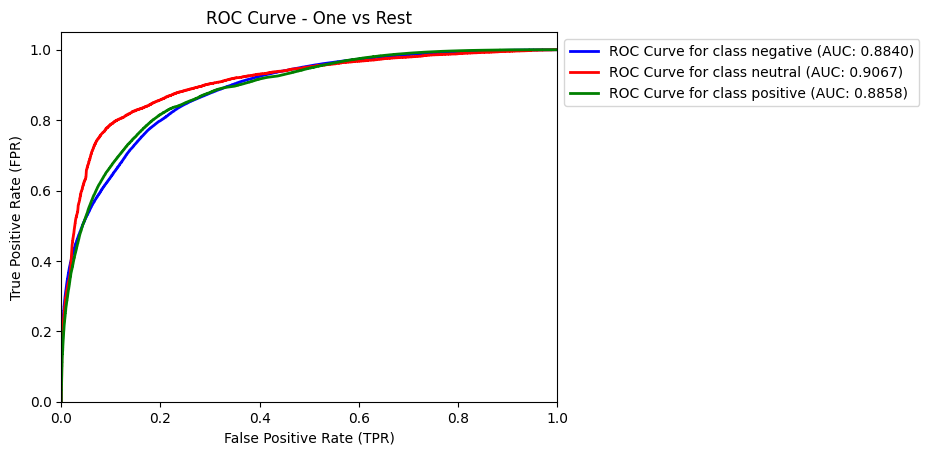

In [ ]:
# color context:
# blue - class 0 - negative sentiment
# red - class 1 - neutral sentiment
# green - class 2 - positive sentiment

import matplotlib.pyplot as plt
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = 2, label = 'ROC Curve for class {0} (AUC: {1:0.4f})'.format(classes[i], roc_auc[i]))

#plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (TPR)')
plt.ylabel('True Positive Rate (FPR)')
plt.title('ROC Curve - One vs Rest')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

The AUC-ROC scores are similar for positive and negative,
and the score for the neutral clas is the highest.